three trained models are saved : 1. Impute model 2. Resampling model 3.Machine learning model

training for LR model

# APS Failure at Scania Trucks

## Introduction

-The dataset consists of data collected from heavy Scania
trucks in everyday usage. The system in focus is the
Air Pressure system (APS) which generates pressurised
air that are utilized in various functions in a truck,
such as braking and gear changes. The datasets'
positive class consists of component failures
for a specific component of the APS system.
The negative class consists of trucks with failures
for components not related to the APS. The data consists
of a subset of all available data, selected by experts.


- The training set contains 60000 examples in total in which
59000 belong to the negative class and 1000 positive class.
The test set contains 16000 examples.

-  Number of Attributes: 171 

-  Attribute Information:
The attribute names of the data have been anonymized for
proprietary reasons. It consists of both single numerical
counters and histograms consisting of bins with different
conditions. Typically the histograms have open-ended
conditions at each end. For example if we measuring
the ambient temperature 'T' then the histogram could
be defined with 4 bins where:
- bin 1 collect values for temperature T < -20
- bin 2 collect values for temperature T >= -20 and T < 0
- bin 3 collect values for temperature T >= 0 and T < 20
- bin 4 collect values for temperature T > 20



In [1]:
#import all the necessary libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
import seaborn as sns
from sklearn.decomposition import pca
from datetime import datetime
from fancyimpute import SoftImpute
from impyute.imputation.cs import mice
from tqdm import tqdm
import missingno as msno
from sklearn.decomposition import pca
from datetime import datetime
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pickle

Using TensorFlow backend.


## 1. Reading Data

### 1.1 Train data

In [2]:
#Obtain the training data from csv file
train_data = pd.read_csv('aps_failure_training_set.csv')
#train_data1 = pd.read_csv('aps_failure_training_set.csv')
# Distribution of data
print("Train Data:")
print("Number of datapoints: {}\nNumber of Features: {}".format(train_data.shape[0],train_data.shape[1]))

Train Data:
Number of datapoints: 60000
Number of Features: 171


In [3]:
train_data.head(5)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


## 2. Data Preprocessing

### 2.1 Missing data processing:

In [4]:
def missing_value(data):
    
    # processing all missing data and combining them in one format
    data.replace(to_replace = ['nan','na','NA','n.a.','?','--','n/a'], value = np.NaN, inplace = True)
    
    #replacing all class labels : train data
    # Source : https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
    #neg = 0  #pos = 1
    data['class'] = data['class'].map({'neg':0,'pos':1}) 
    
    #Seperating the class labels : train data
    y_train = data['class']
    data.drop(['class'], axis = 1, inplace= True)
    
    
    #Calculating the number of missing values
    missing_value = data.isnull().sum()
    # sorting features with missing value : highest to lowest
    missing_col = missing_value.sort_values(ascending = False)
        #print('Sorted data based on missing values : \n',missing_col)
    #plotting the features with missing values
    missing_col.plot.bar(figsize=(50,20))
    plt.xlabel('Feature names',fontsize=30)
    plt.ylabel('Missing value count',fontsize=30)
        #plt.show()
    
    #Processing missing values
    
    # Code to identify rows which contains features(less than 5% missing values)

    missing_rvalue = data.isnull().sum(axis=1)
    missing_row = missing_rvalue.sort_values(ascending = False)
    #print(missing_row)
    
    missing_per = (missing_col/len(data))*100
        #print('Missing value percentage of train data: \n',missing_per)
    
    return missing_per,data,y_train
    

### 2.2 Model based Imputation

In [5]:
#https://gist.github.com/michelkana/6175ef96b44311ccbdca3cb8fddca53c
def impute_model(df):
    
    from sklearn.ensemble import RandomForestRegressor
    #getting the missing value feature
    # Cols_nan =  Column still remain with na values
    # cols_no_nan = Columns which have zero nan values
    cols_nan = df.columns[df.isna().any()].tolist()
    #print('Number of Columns with NA values : ',len(cols_nan),'column list : ',cols_nan)
    
    cols_no_nan = df.columns.difference(cols_nan).values.tolist()
    #print('Number of Columns without NA values : ',len(cols_no_nan),'column list : ',cols_no_nan)    
    
    model_impute = []
    
    for col in cols_nan:
        #Creating the train data
        train_data = df.dropna()
        X_train = train_data[cols_no_nan] 
        y_train = train_data[col]
            
        #creating the test data
        test_data = df[df[col].isna()]
        X_test = test_data[cols_no_nan]
        y_test = test_data[col]
            
        #using the model based imputation
        rf = RandomForestRegressor()
        rfr = rf.fit(X_train,y_train)
        
        model_impute.append(rfr)
        
        
        #replacing the actual features
        df.loc[df[col].isna(),col] = rfr.predict(X_test)
        #print('The feature {} is processed'.format(col))
    
    return df,model_impute

### 2.3 Creating Processed train data file :

In [6]:
def dtrain(data):
    
    n_estimators=40
    
    #call function for missing value information
    missing_per,train_data,y_train = missing_value(data)
    
    # 4 steps to work on missing value data
    
    # 1. Dropping column with missing value greater than 85%
        # Identifying features having higher percentage of missing value
    missing_features1 = missing_per[missing_per > 85].index
    train_data1 = train_data.drop(missing_features1,axis=1,inplace=False)
        #print(train_data1.shape)
   

    # 2. Dropping rows for missing value less than 5%
    missing_feature2 = missing_per[missing_per < 5].index
    train_data2 = train_data1.dropna(subset = missing_feature2,axis=0,inplace=False)
        #print(train_data2)
    
    # Converting Object into numeric features
    for mis in missing_feature2:
        train_data2[mis] = pd.to_numeric(train_data2[mis],errors='coerce')
    
    # 3. Median Imputation for missing value between 5% to 20%
    
    #missing feature 3 is the feature with missing values between 5% to 20%
    missing_feature3 = ((missing_per[missing_per >= 5].index) & (missing_per[missing_per < 20].index))
    
    for mis in missing_feature3:
        train_data2[mis] = train_data2[mis].fillna(train_data2[mis].median())
    
    # Converting Object into numeric features
    for mis in missing_feature3:
        train_data2[mis] = pd.to_numeric(train_data2[mis],errors='coerce')
    
    # 4. Model based imputation for missing value between 20% to 85%
    
    missing_feature4 = ((missing_per[missing_per >= 20].index) & (missing_per[missing_per < 85].index))
    # Displaying missing values count
    train_data3 = train_data2[missing_feature4]
    #print(train_data3.isna().sum().sort_values(ascending=False))
    
    start = datetime.now()
    df,model_impute = impute_model(train_data2)
    print('Time taken to process : ',datetime.now() - start)
    
    # Saving the trained imputation model
    filename = 'imputation.sav'
    pickle.dump(model_impute,open(filename,'wb'))
    
    #Converting object features into numeric one
    for mis in missing_feature4:
        df[mis] = pd.to_numeric(df[mis],errors='coerce')

    # Saving the data in csv file
    df['class'] = y_train
    df.to_csv('processed_train_data_final.csv')
    
   

Time taken to process :  2:22:11.215621


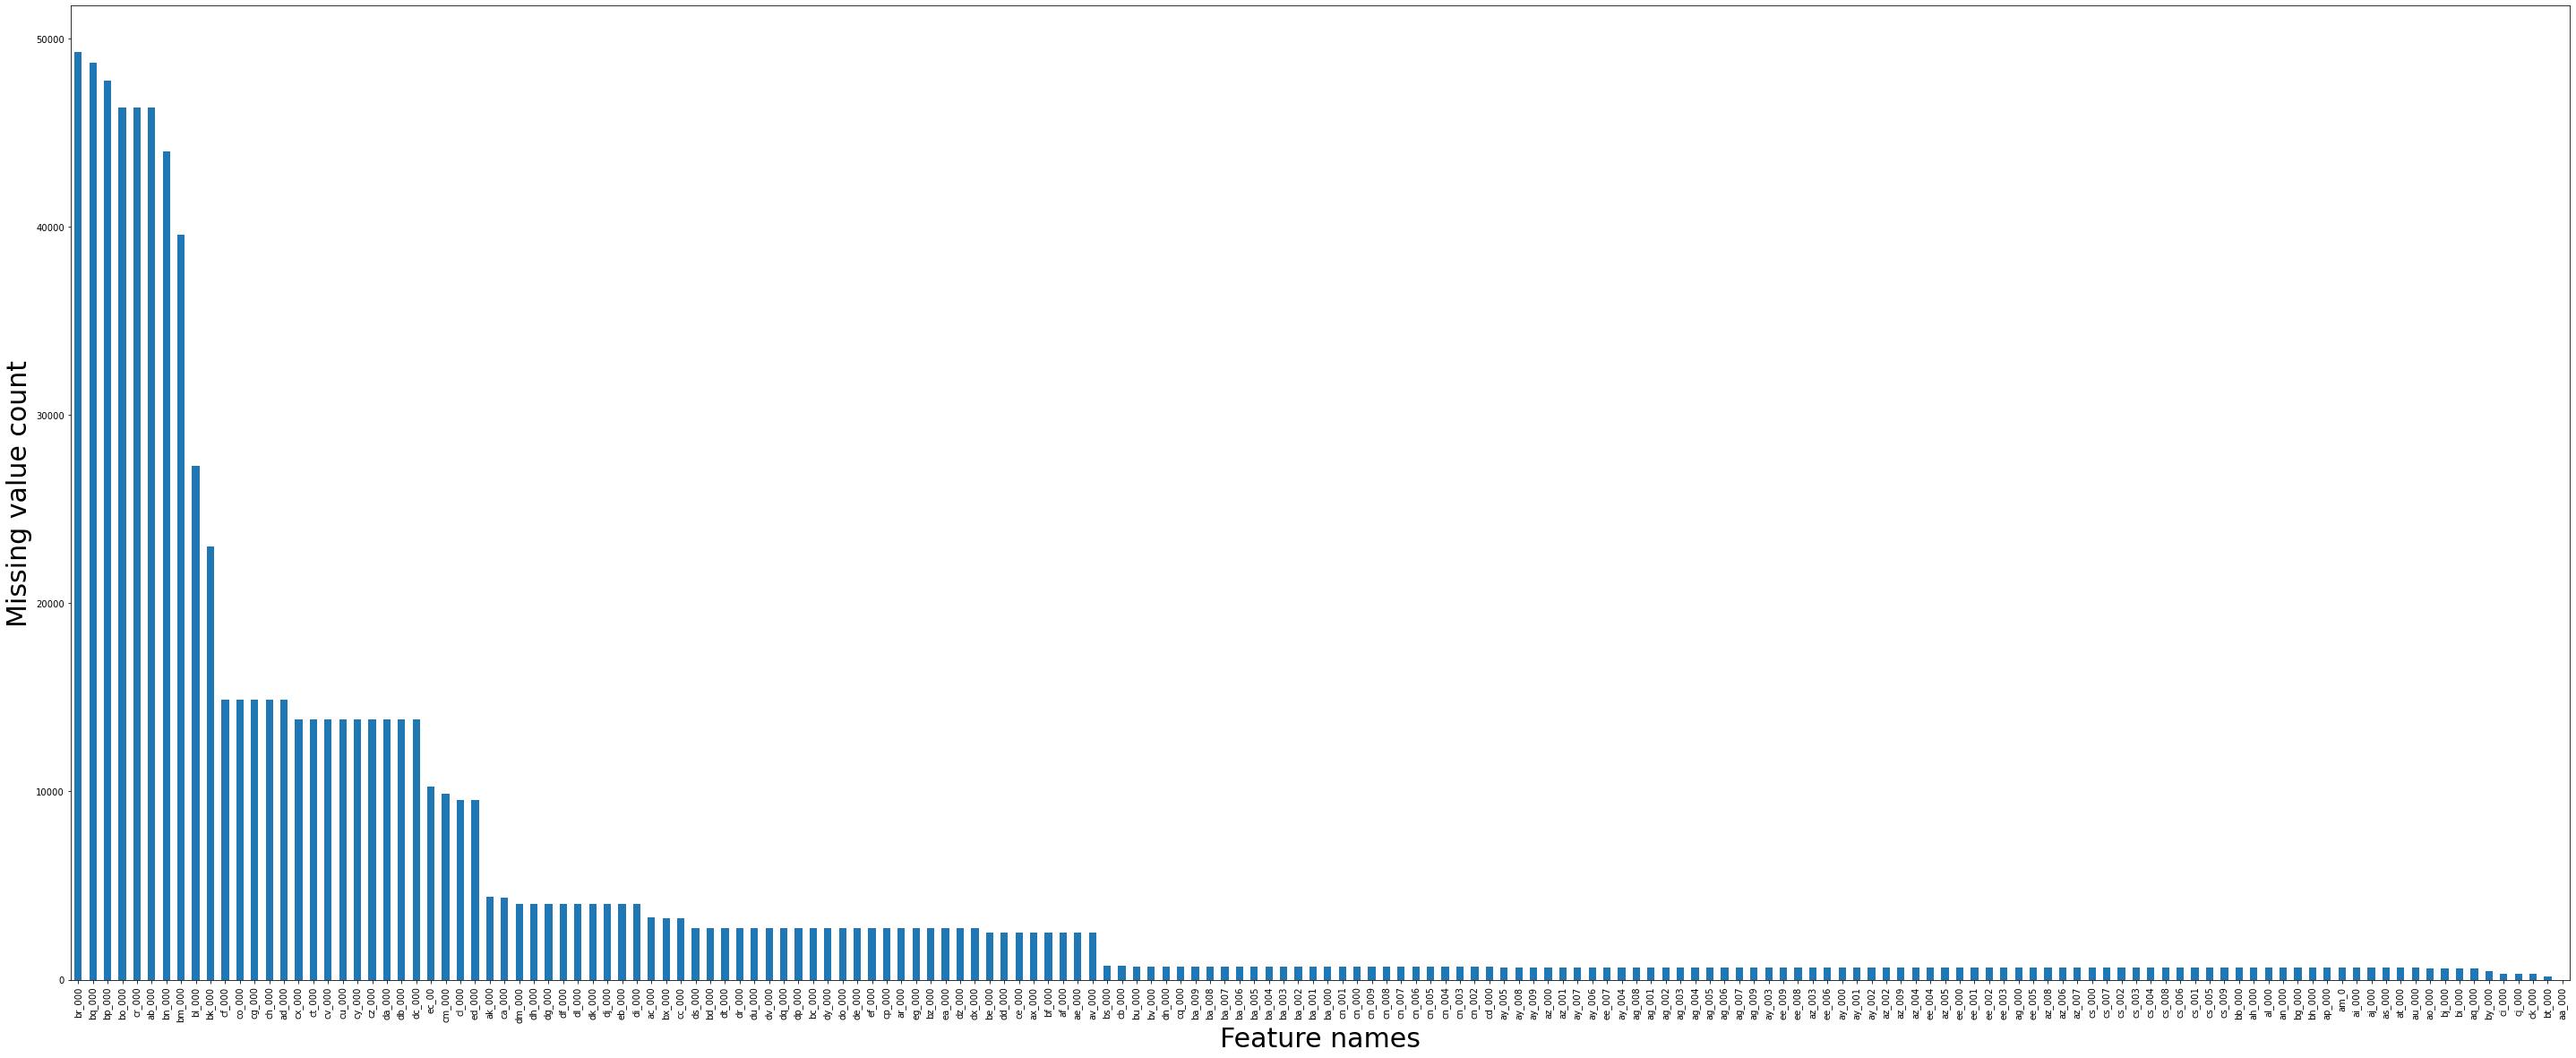

In [8]:
# Create the processed file
dtrain(train_data)

## 3. Train the Data 

### 3.1 Reading processed data :

In [7]:
train_data =  pd.read_csv('processed_train_data_final.csv')
#seperating the class label
y = train_data['class']
train_data.drop(['Unnamed: 0','class'],inplace=True,axis=1)

### 3.2. Splitting Dataset : Train and Test (80:20)

In [8]:
#Splitting the data set into 80:20
X_train,X_test,y_train,y_test = train_test_split(train_data,y,test_size=0.2,random_state=4,stratify=y)  

In [9]:
print('Train data size: ',X_train.shape)
print('Test data size: ', X_test.shape)

Train data size:  (44748, 170)
Test data size:  (11188, 170)


In [10]:
from collections import Counter
print('Complete data set distribution: ',Counter(y))
print('Train data set distribution: ',Counter(y_train))
print('Test data set distribution: ',Counter(y_test))

Complete data set distribution:  Counter({0: 55340, 1: 596})
Train data set distribution:  Counter({0: 44271, 1: 477})
Test data set distribution:  Counter({0: 11069, 1: 119})


## 4 Data preprocessing 2 : 

### 4.1 Resampling dataset :

In [11]:
def get_resampling(df_train,y1,estimators,D2,X_test):
    
    df_train['class'] = y1
    
    # Resampling the dataset
    df_list = []
    for i in range(estimators):
        df = df_train.sample(frac=0.4,replace=True)
        df_list.append(df)    
    
    #print(estimators)
    #print(len(df_list))
    #print(df_list[2])
    # Seperating class label from resampled dataset
    y1_list = []
    for i in range(estimators):
        df = df_list[i]
        y1 = df['class']
        df.drop(['class'],inplace=True,axis=1)
        y1_list.append(y1)
        
    #Creating Model datasets
    
    # training the dataset

    pred_D2_dataset = []
    pred_test_dataset = []
    #pred_test_final = []
    sample_model = []
    
    for iters in range(estimators):
        
        train_df = df_list[iters]
        train_y1 = y1_list[iters]

        model =  DecisionTreeClassifier(max_depth=3)
        model.fit(train_df,train_y1)
    
        sample_model.append(model)

        # Calculating and storing variable of D2 dataset individually in a list
        y_pred = model.predict(D2)
        pred_D2_dataset.append(y_pred)
    
        # Calculating and storing variable of test dataset individually in a list
        y_test_pred = model.predict(X_test)
        pred_test_dataset.append(y_test_pred)
        
    
    # Transposing the predicted dataset
    pred_D2_dataset = np.array(pred_D2_dataset).T
    pred_test_dataset = np.array(pred_test_dataset).T
    #pred_test_final = np.array(pred_test_final).T
    
    #Adding newly created features with existing features and transforming it into dataframe
    D2_meta = pd.DataFrame(pred_D2_dataset)
    D_test_meta = pd.DataFrame(pred_test_dataset)
    
    return D2_meta,D_test_meta,sample_model


__Observations : 1. estimators decide the number of decision trees__

__2. Resampling with replacement is done with 40% of D1 data__

__3. In resampling y values are accomodated to maintain the integrity of data__

__4. Each resampled(D1) dataset is trained using classifier and predicted dataset for D2 and X_test is created__

__5. Since all process are done parallely, we have equal no of features created for D1,D2 and X_test which depends on value of n_estimators__

__6. Since we are using Decisiontree as a base classifier, we dont need Normalizer and SMOTE data balancing__

### 4.2 Data Balancing : SMOTE

In [12]:
def get_smote(data,y):
    
    # transform the dataset
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    #Oversampling the minority samples
    oversample = SMOTE(sampling_strategy=0.6)
    #under sampling the majority samples
    undersample = RandomUnderSampler(sampling_strategy = 1.0)
    
    # setting up sequence of sampling
    steps = [('o',oversample),('u',undersample)]
    pipeline = Pipeline(steps=steps)
    
    #transform the dataset
    smote_data,smote_y = pipeline.fit_resample(data,y)
    
    return smote_data,smote_y


### 4.3 Score 

In [13]:
def get_score(meta_model_D2,y2,meta_model_test,y_test):
    
    model_lr = LogisticRegression(random_state=0,class_weight='balanced')
    model_lr.fit(meta_model_D2,y2)
    
    y_pred_test = model_lr.predict(meta_model_test)

    #calculate acc,f1 score
    #accuracy score
    accuracy = accuracy_score(y_test,y_pred_test)
    print('Accuracy : %.3f' % accuracy)
    #precision
    precision = precision_score(y_test,y_pred_test)
    print('Precision : %.3f' % precision)
    #Recall
    recal = recall_score(y_test,y_pred_test)
    print('Recall : %.3f' % recal)
    #f1 score
    f1 = f1_score(y_test,y_pred_test)
    print('f1_score : %.3f' % f1)
    
    return y_pred_test,model_lr

### 4.4 Plotting Confusion Matrix : 

In [14]:
def get_confusion_matrix(y_test,y_pred_test): 
    #ROC AUC score
    auc = roc_auc_score(y_test,y_pred_test)
    print('AUC score: %.3f' % auc)
    #confusion matrix
    cm_test = confusion_matrix(y_test,y_pred_test)
    #print('Confusion Matrix :\n', matrix)
    print('-'*120)
    print('Confusion Matrix :','\n',cm_test)
    #print(con_matr)
    print('-'*120)
    print("Type 1 error (False Positives) : ",cm_test[0][1])
    print('Type 2 error (False Negatives) :',cm_test[1][0])
    print('-'*120)
    Total_cost = cm_test[0][1]*10 + cm_test[1][0]*500
    print('Total Cost = ',Total_cost)
    print('-'*120)
    
    return Total_cost

__Observations : 1. Confusion Matrix summarizes the performance of model__

__2. Total cost involves all the readings with incorrect predictions multiplied by their respective weights__

__3. False Negative has 50 times more weightage than False Positive in calculating performance of model__

## 5. Main Function

In [15]:
def custom_ensemble(X_train,y_train,X_test,y_test,n_estimators):
    
    print('-'*100)
    print('Number of Estimators : ',n_estimators)
    print('-'*100)
    #Splitting the train dataset 50:50
    D1,D2,y1,y2 = train_test_split(X_train,y_train,test_size=0.5,random_state=5,stratify=y_train)
    
    #Using SMOTE for balancing training D1 data : Using function
    smote_D1,smote_y1 = get_smote(D1,y1)
    
    # Normalizing the data : using function
        #smote_D1,D2,X_test,X_test_final = get_normalized(smote_D1,D2,X_test,X_test_final)
    
    #Using n_estimators creating resampling dataset & get meta models : using function
    meta_model_D2,meta_model_test,sample_model = get_resampling(D1,y1,n_estimators,D2,X_test) 

    #get the score
    y_pred_test,clf = get_score(meta_model_D2,y2,meta_model_test,y_test)
    
    #Plot Confusion Matrix
    
    plot_confusion_matrix(clf,meta_model_test,y_test)
    
    cost = get_confusion_matrix(y_test,y_pred_test)
    
    return cost

----------------------------------------------------------------------------------------------------
Number of Estimators :  10
----------------------------------------------------------------------------------------------------
Accuracy : 0.986
Precision : 0.409
Recall : 0.790
f1_score : 0.539
AUC score: 0.889
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix : 
 [[10933   136]
 [   25    94]]
------------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positives) :  136
Type 2 error (False Negatives) : 25
------------------------------------------------------------------------------------------------------------------------
Total Cost =  13860
------------------------------------------------------------------------------------------------------------------------
13860
---------------------------------------------------

Accuracy : 0.986
Precision : 0.417
Recall : 0.765
f1_score : 0.540
AUC score: 0.877
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix : 
 [[10942   127]
 [   28    91]]
------------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positives) :  127
Type 2 error (False Negatives) : 28
------------------------------------------------------------------------------------------------------------------------
Total Cost =  15270
------------------------------------------------------------------------------------------------------------------------
15270
----------------------------------------------------------------------------------------------------
Number of Estimators :  110
----------------------------------------------------------------------------------------------------
Accuracy : 0.987
Precision : 0.439
Recall : 0.731


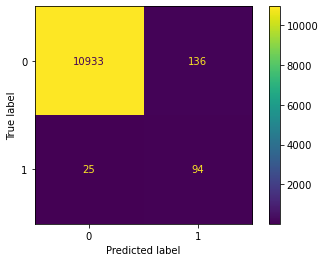

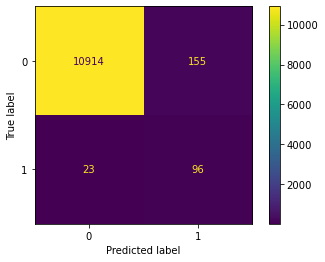

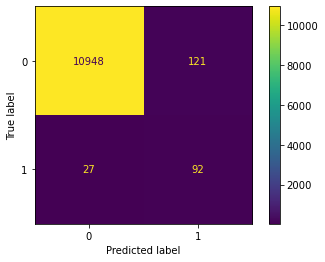

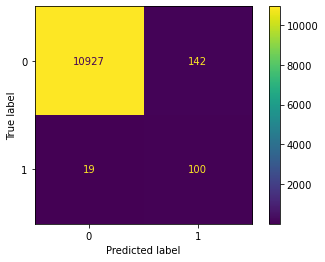

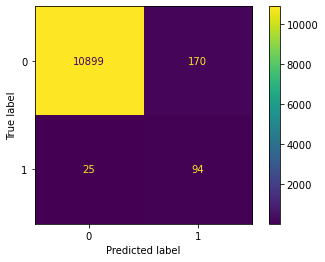

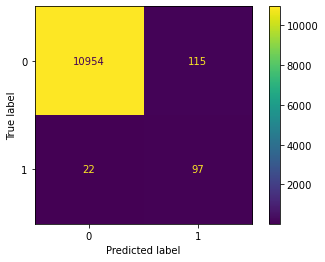

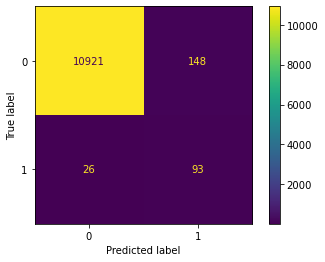

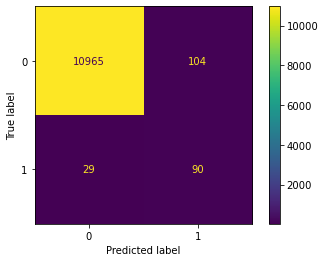

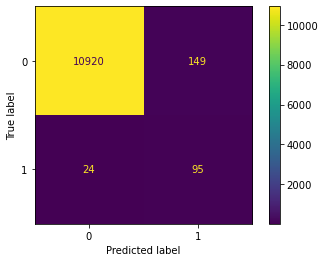

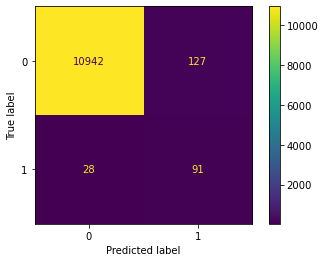

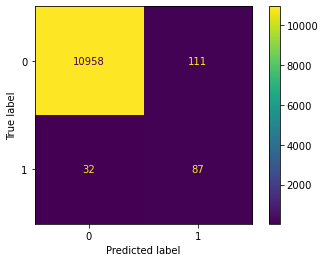

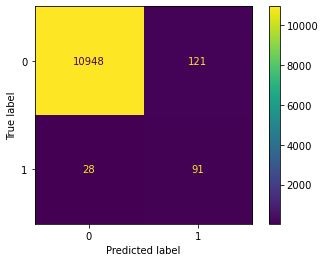

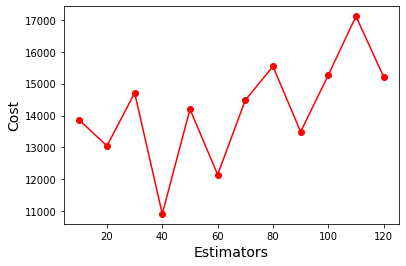

In [16]:
#Runnning the Code

estimators_list = [10,20,30,40,50,60,70,80,90,100,110,120]
t_cost = []

start = datetime.now()

for estimators in estimators_list:
    
    Total_cost = custom_ensemble(X_train,y_train,X_test,y_test,n_estimators=estimators)
    t_cost.append(Total_cost)
    print(Total_cost)

print('Time taken to process : ',datetime.now()-start)
fig,ax = plt.subplots()
#make a plot
ax.plot(estimators_list,t_cost,color='red',marker='o')
#set x axis
ax.set_xlabel('Estimators',fontsize=14)
#set y axis
ax.set_ylabel('Cost',fontsize=14)

plt.show()

#print(Total_cost)

__Observations : Using machine learning model, the above code help us to find out the optimum number of estimators__

## 8 Hyperparameter Tuning 

In [17]:
n_estimators = 80
#Splitting the train dataset 50:50
D1,D2,y1,y2 = train_test_split(X_train,y_train,test_size=0.5,random_state=5,stratify=y_train)
    
    
#Using n_estimators creating resampling dataset & get meta models : using function
meta_model_D2,meta_model_test,sample_model1 = get_resampling(D1,y1,n_estimators,D2,X_test) 
    
#Creating resampling model
filename = 'resamplingLR80.sav'
pickle.dump(sample_model1,open(filename,'wb'))
    


### 8.1 Logistic Regression : C parameter

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(n_jobs=-1, random_state=0)

penalty = ['l1','l2']

C = np.logspace(-4,4,9)

hyperparameters = dict(C=C,penalty=penalty,solver=['liblinear'])

clf_log = GridSearchCV(clf,hyperparameters,cv=3,verbose=True,n_jobs=-1)

clf_log.fit(meta_model_D2,y2)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    2.7s finished


GridSearchCV(cv=3, estimator=LogisticRegression(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [19]:
print("Best Penalty : ",clf_log.best_estimator_.get_params()['penalty'])
print("Best C : ",clf_log.best_estimator_.get_params()['C'])

Best Penalty :  l1
Best C :  1.0


In [20]:
K = clf_log.best_estimator_.get_params()['C']

### 8.2 Logistic Regression : class weight

In [21]:
cls_weight = [{0:10,1:1},{0:1,1:1},{0:1,1:10},{0:1,1:100},{0:1,1:500}]
for i in range(len(cls_weight)):
    balance = cls_weight[i]
    print(balance)
    clf_logit = LogisticRegression(n_jobs=-1,random_state=0,C=K,penalty='l2',class_weight=balance)
    clf_logit.fit(meta_model_D2,y2)
    #THRESHOLD=0.5
    #y_pred = np.where(clf_logit.predict_proba(meta_model_test)[:,1]> THRESHOLD,1,0)
    y_pred = clf_logit.predict(meta_model_test)

    cost = get_confusion_matrix(y_test,y_pred)

{0: 10, 1: 1}
AUC score: 0.710
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix : 
 [[11063     6]
 [   69    50]]
------------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positives) :  6
Type 2 error (False Negatives) : 69
------------------------------------------------------------------------------------------------------------------------
Total Cost =  34560
------------------------------------------------------------------------------------------------------------------------
{0: 1, 1: 1}
AUC score: 0.764
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix : 
 [[11044    25]
 [   56    63]]
------------------------------------------------------------------------------------------------------------------------
Type 1 error (Fal

## 9. Pretraining Model

In [22]:
clf_logit = LogisticRegression(n_jobs=-1,random_state=0,C=K,penalty='l2',class_weight={0:1,1:500})
clf_logit.fit(meta_model_D2,y2)
#THRESHOLD=0.5
#y_pred = np.where(clf_logit.predict_proba(meta_model_test)[:,1]> THRESHOLD,1,0)
y_pred = clf_logit.predict(meta_model_test)

cost = get_confusion_matrix(y_test,y_pred)

AUC score: 0.908
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix : 
 [[10897   172]
 [   20    99]]
------------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positives) :  172
Type 2 error (False Negatives) : 20
------------------------------------------------------------------------------------------------------------------------
Total Cost =  11720
------------------------------------------------------------------------------------------------------------------------


In [23]:
#accuracy score
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy : %.3f' % accuracy)
#precision
precision = precision_score(y_test,y_pred)
print('Precision : %.3f' % precision)
#Recall
recal = recall_score(y_test,y_pred)
print('Recall : %.3f' % recal)
#f1 score
f1 = f1_score(y_test,y_pred)
print('f1_score : %.3f' % f1)

Accuracy : 0.983
Precision : 0.365
Recall : 0.832
f1_score : 0.508


In [24]:
#Saving the model to disk
filename = 'Model_LR80.sav'
pickle.dump(clf_logit,open(filename,'wb'))